In [72]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import os
import sys
plt.style.use('seaborn-v0_8-dark-palette')
# change the police in plots to SERIF
plt.rcParams['font.family'] = 'serif'

# Add the parent directory to sys.path to import local modules
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
	sys.path.append(module_path)

from streamingModels.StreamRegressionModels import PARegressor
import matplotlib.pyplot as plt
from river import metrics
from river import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [118]:
def prepare_data(csv_path):
    # Read the CSV file
    df = pd.read_csv(csv_path)
    # drop unnamed column
    df = df.drop(columns=['Unnamed: 0'])
    
    # Ensure datetime columns are in the correct format
    df['start_time'] = pd.to_datetime(df['date']).dt.strftime('%d-%m-%Y %H:%M:%S')
    df['end_time'] = (pd.to_datetime(df['date']) + pd.Timedelta(minutes=1)).dt.strftime('%d-%m-%Y %H:%M:%S')
    
    return df
# Load your data
csv_btc = './Bdata/BTCUSDT.csv'  # Your CSV path
csv_eth = './Bdata/ETHUSDT.csv'  # Your CSV path
csv_ada = './Bdata/ADAUSDT.csv'  # Your CSV path
df_btc = prepare_data(csv_btc)
df_eth = prepare_data(csv_eth)
df_ada = prepare_data(csv_ada)

In [119]:
df_btc.head()

,date,open,high,low,close,volume,SMA_20,EMA_50,RSI,stoch_k,...,lag_4,lag_5,lag_6,lag_7,lag_8,rolling_mean,rolling_std,target,start_time,end_time
0,2025-01-20 01:10:00,100236.02,100420.14,99921.18,100214.58,364.79680,100694.7950,100180.720153,44.404996,31.234520,...,100095.64,99721.95,100762.71,99857.92,100892.00,100070.86000,339.272273,0.004445,20-01-2025 01:10:00,20-01-2025 01:11:00
1,2025-01-20 01:15:00,100214.58,100459.06,99910.73,100200.29,233.97171,100721.4515,100181.487598,40.604029,32.534346,...,99794.51,100095.64,99721.95,100762.71,99857.92,100113.65625,330.042477,-0.001178,20-01-2025 01:15:00,20-01-2025 01:16:00
2,2025-01-20 01:20:00,100200.29,100203.08,99745.00,100162.97,228.33874,100669.0465,100180.761418,38.412483,30.667207,...,99883.55,99794.51,100095.64,99721.95,100762.71,100038.68875,206.569366,0.002098,20-01-2025 01:20:00,20-01-2025 01:21:00
3,2025-01-20 01:25:00,100162.97,100518.05,100009.62,100320.00,279.41480,100596.0700,100186.221754,42.990889,38.523499,...,100236.02,99883.55,99794.51,100095.64,99721.95,100113.44500,182.365774,-0.001425,20-01-2025 01:25:00,20-01-2025 01:26:00
4,2025-01-20 01:30:00,100320.00,100656.84,100113.20,100584.00,345.33619,100554.5495,100201.820901,42.098164,51.731556,...,100214.58,100236.02,99883.55,99794.51,100095.64,100174.49000,246.139909,0.001082,20-01-2025 01:30:00,20-01-2025 01:31:00


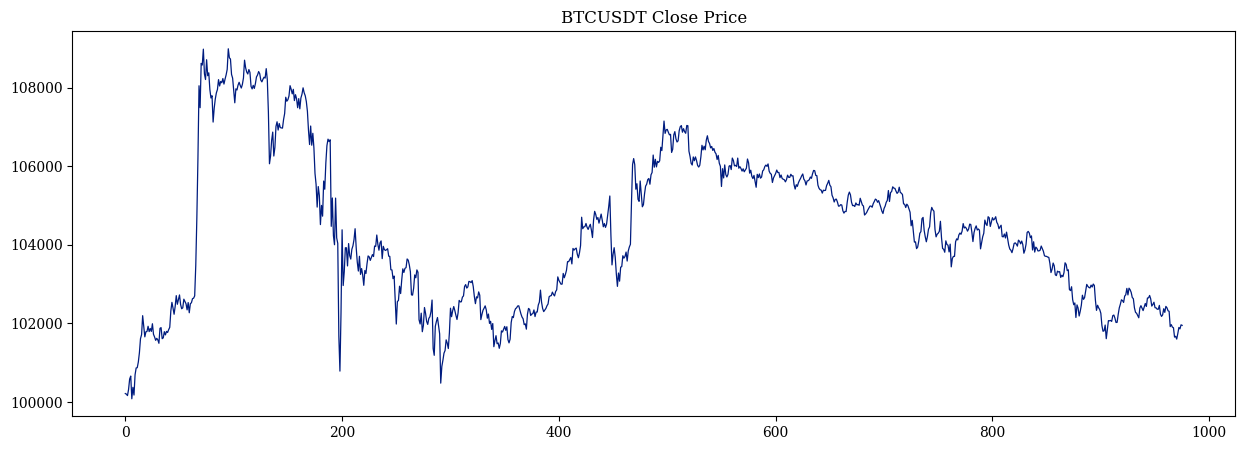

In [120]:
plt.figure(figsize=(15, 5))
plt.plot(df_btc['close'], linewidth=0.9)
plt.title('BTCUSDT Close Price')
plt.show()


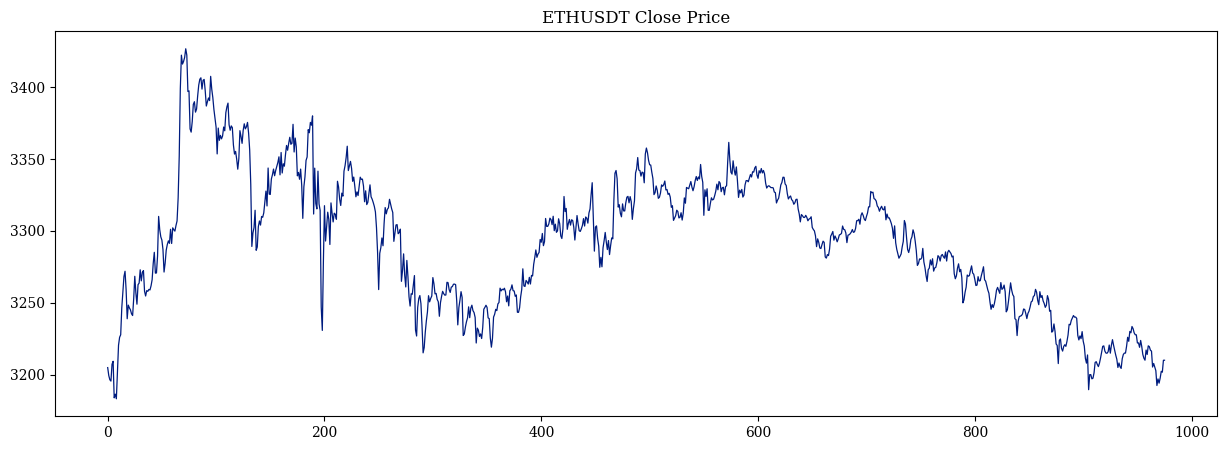

In [97]:
plt.figure(figsize=(15, 5))
plt.plot(df_eth['close'], linewidth=0.9)
plt.title('ETHUSDT Close Price')
plt.show()


In [98]:
# calculate correlation
btc_corr = df_btc['close'].corr(df_ada['close'])

print(f'Correlation between BTCUSDT and ADAUSDT: {btc_corr}')

Correlation between BTCUSDT and ADAUSDT: 0.7508980135957656


In [79]:
import pandas as pd
import numpy as np
from river import linear_model, ensemble, neighbors, tree, time_series, neural_net as nn, preprocessing as pp, optim, forest
from river.metrics import RMSE, MAE, R2, MAPE
from river.stream import iter_pandas

In [99]:
models = {
    'LinearRegression':  pp.StandardScaler() | linear_model.LinearRegression(intercept_lr=.0001),
    'PARegressor': linear_model.PARegressor(C=1, learn_intercept=False),
    'ARF': pp.StandardScaler() | forest.ARFRegressor(seed=42),
    'KNNRegressor': neighbors.KNNRegressor()

}

# Initialize metrics
metrics = {
    'LinearRegression': {'rmse': RMSE(), 'mae': MAE(), 'r2': R2(), 'mape': MAPE()},
    'PARegressor': {'rmse': RMSE(), 'mae': MAE(), 'r2': R2(), 'mape': MAPE()},
    'ARF': {'rmse': RMSE(), 'mae': MAE(), 'r2': R2(), 'mape': MAPE()},
    'KNNRegressor': {'rmse': RMSE(), 'mae': MAE(), 'r2': R2(), 'mape': MAPE()}

}

# Store results for plotting
predictions = {model: [] for model in models}
metrics_values = {model: {metric: [] for metric in metrics[model]} for model in models}
real_values = []

In [100]:
from tqdm import tqdm

In [101]:
import time
from tqdm import tqdm

# Initialize a dictionary to store timing metrics
time_metrics = {model_name: [] for model_name in models.keys()}

# Record overall computation time
overall_start_time = time.time()

# Stream through data and update models
for idx, row in tqdm(df_btc.iterrows(), total=len(df_btc), colour='green'):
    # X: a dictionary containing all the features of the current row
    X = {feature: row[feature] for feature in df_btc.columns if feature != 'close' and feature not in ['date', 'start_time', 'end_time']}
    real_value = float(row['close'])
    real_values.append(real_value)

    # Update models and record predictions
    for model_name, model in models.items():
        start_time = time.time()  # Start timing for this model
        
        # Predict and learn
        pred = model.predict_one(X)
        model.learn_one(X, real_value)

        # Update metrics
        metrics[model_name]['rmse'].update(real_value, pred)
        metrics[model_name]['mae'].update(real_value, pred)
        metrics[model_name]['r2'].update(real_value, pred)
        metrics[model_name]['mape'].update(real_value, pred)

        # Record metric values
        metrics_values[model_name]['rmse'].append(metrics[model_name]['rmse'].get())
        metrics_values[model_name]['mae'].append(metrics[model_name]['mae'].get())
        metrics_values[model_name]['r2'].append(metrics[model_name]['r2'].get())
        metrics_values[model_name]['mape'].append(metrics[model_name]['mape'].get())

        predictions[model_name].append(pred)

        end_time = time.time()  # End timing for this model
        time_metrics[model_name].append(end_time - start_time)  # Record the computation time for this model

# Record overall computation time
overall_end_time = time.time()
overall_time = overall_end_time - overall_start_time

# Print timing results
print(f"Overall computation time: {overall_time:.2f} seconds")
for model_name, times in time_metrics.items():
    avg_time = sum(times) / len(times)
    print(f"Average computation time for {model_name}: {avg_time:.5f} seconds per update")


100%|██████████| 976/976 [00:23<00:00, 42.05it/s]

Overall computation time: 23.22 seconds
Average computation time for LinearRegression: 0.00033 seconds per update
Average computation time for PARegressor: 0.00017 seconds per update
Average computation time for ARF: 0.00874 seconds per update
Average computation time for KNNRegressor: 0.01371 seconds per update


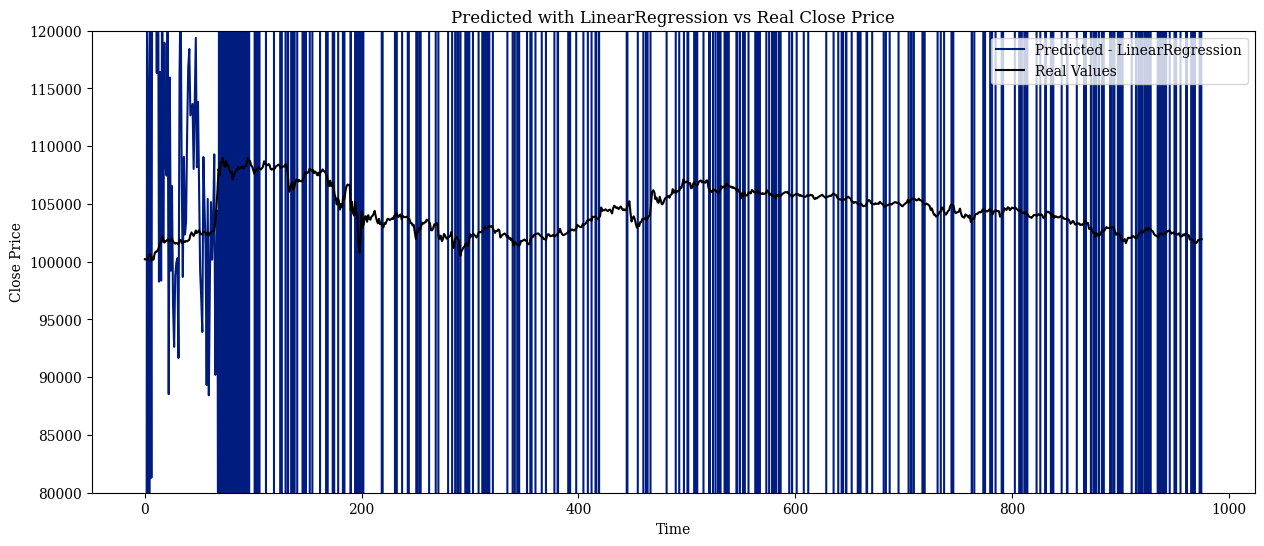

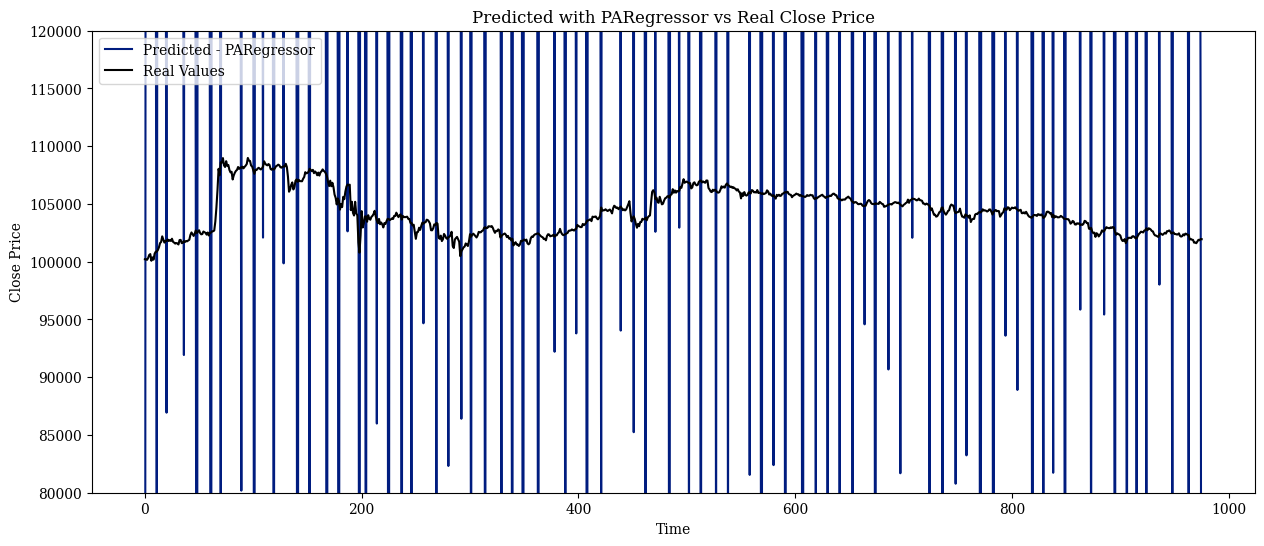

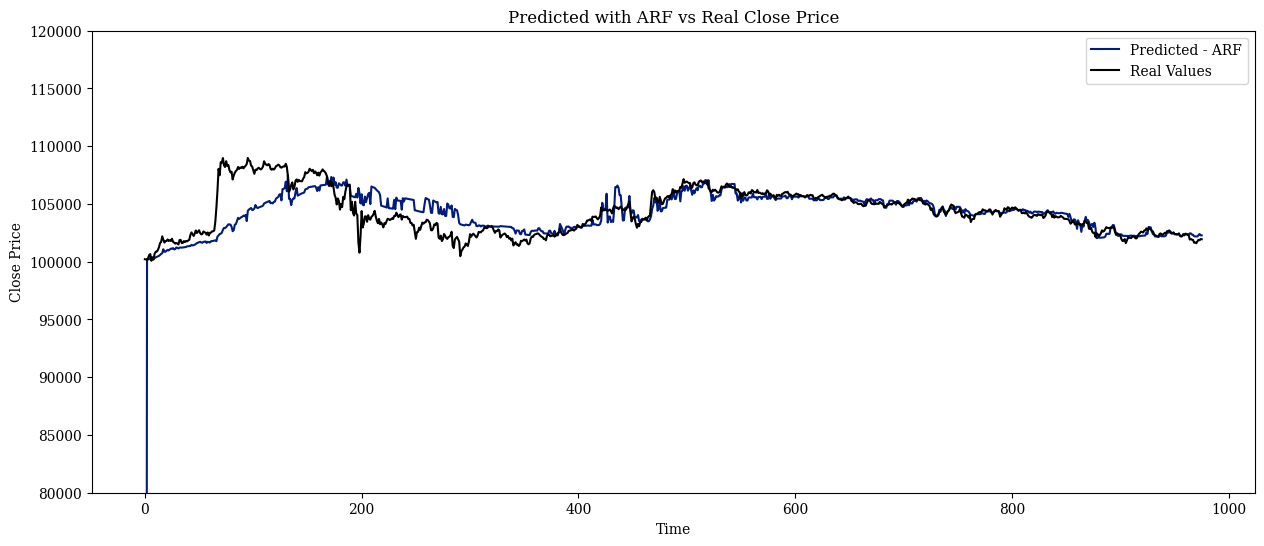

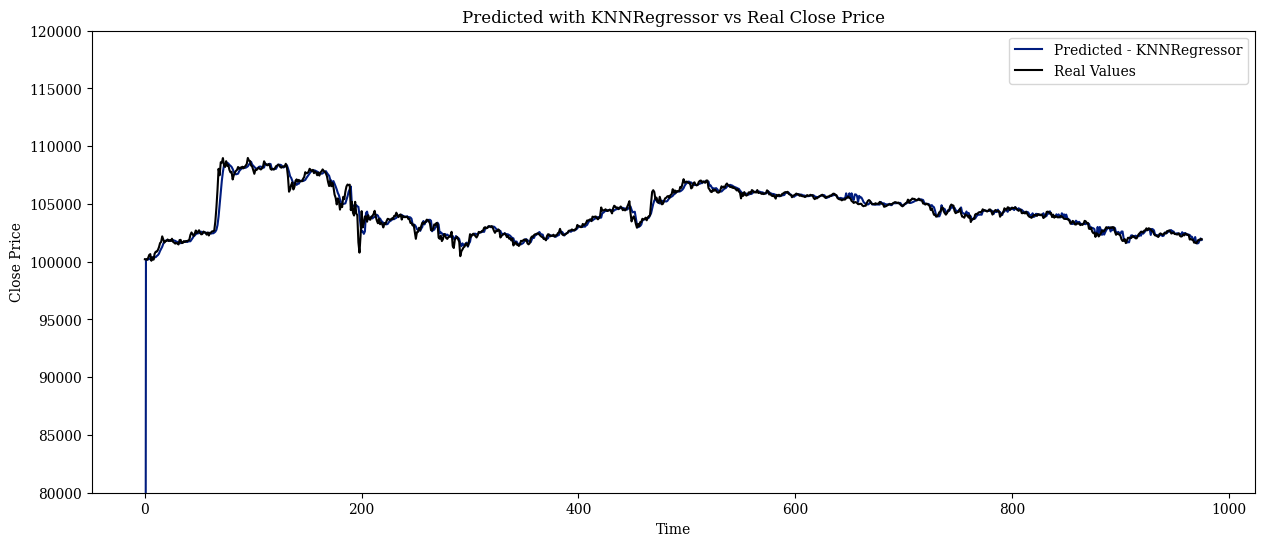

In [103]:
# Plot the predictions vs real values
for model_name in models:
    plt.figure(figsize=(15, 6))
    plt.plot(predictions[model_name], label=f'Predicted - {model_name}')
    plt.plot(real_values, label='Real Values', color='black')
    # crop y axis to see the plot better
    plt.ylim(80000, 120000)
    plt.legend()
    plt.title(f'Predicted with {model_name} vs Real Close Price')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
plt.show()

In [104]:
# Compare metrics for each model
metric_comparison = pd.DataFrame({
    'Model': list(models.keys()),
    'RMSE': [metrics[model_name]['rmse'].get() for model_name in models],
    'MAE': [metrics[model_name]['mae'].get() for model_name in models],
    'R2': [metrics[model_name]['r2'].get() for model_name in models],
    'MAPE': [metrics[model_name]['mape'].get() for model_name in models],
})
metric_comparison

,Model,RMSE,MAE,R2,MAPE
0,LinearRegression,2.653096e+09,3.505076e+08,-1.900216e+12,327010.508073
1,PARegressor,9.054562e+04,8.644792e+04,-2.212259e+03,82.872292
2,ARF,4.515088e+03,1.002409e+03,-4.503383e+00,0.963012
3,KNNRegressor,3.233308e+03,3.344509e+02,-1.822223e+00,0.324352


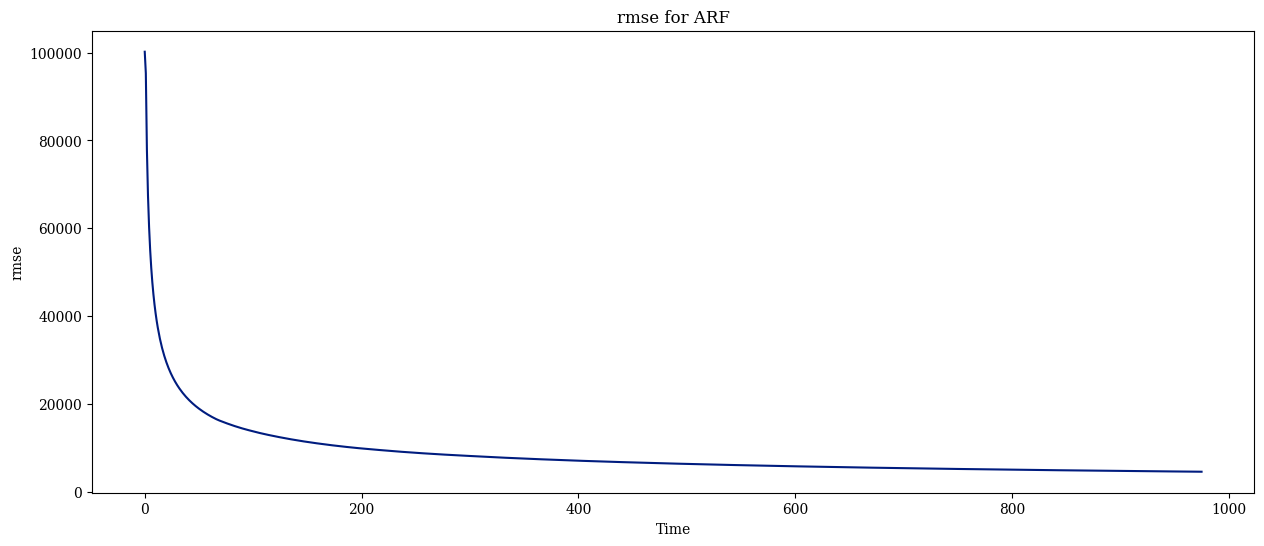

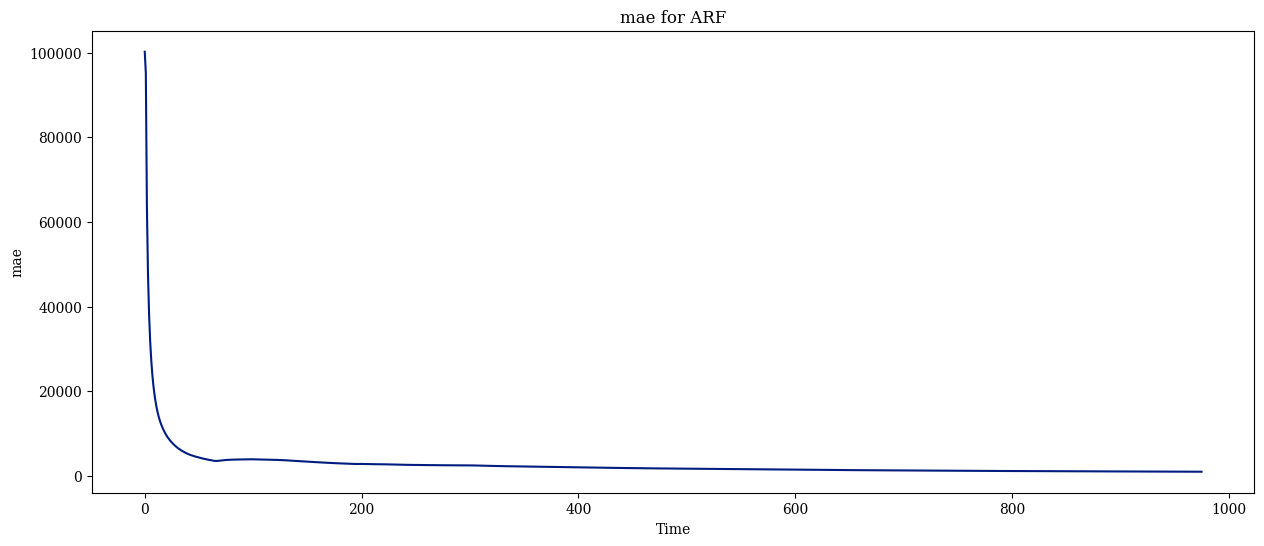

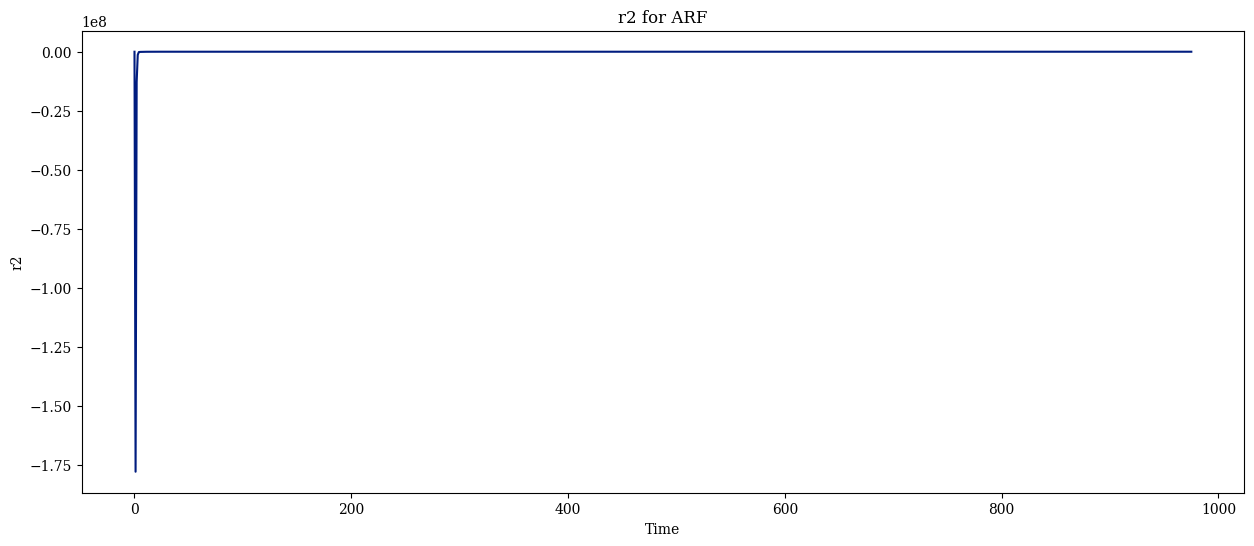

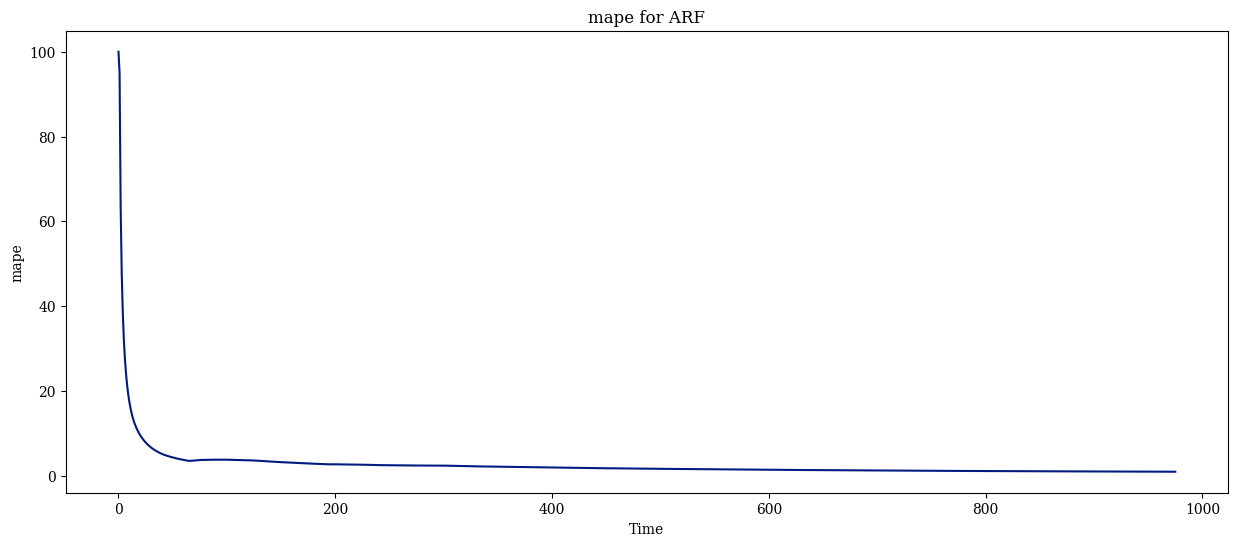

In [105]:
model_to_plot = 'ARF'

for metric in metrics_values[model_to_plot]:
    plt.figure(figsize=(15, 6))
    plt.plot(metrics_values[model_to_plot][metric])
    plt.title(f'{metric} for {model_to_plot}')
    plt.xlabel('Time')
    plt.ylabel(metric)
plt.show()

In [91]:
import plotly.graph_objects as go

model_to_plot = 'KNNRegressor'

# Create a plot for each metric
for metric in metrics_values[model_to_plot]:
    fig = go.Figure()

    # Add a line for the selected metric
    fig.add_trace(go.Scatter(
        y=metrics_values[model_to_plot][metric],
        mode='lines',
        name=metric
    ))

    # Update layout with titles and labels
    fig.update_layout(
        title=f'{metric} for {model_to_plot}',
        xaxis_title='Time',
        yaxis_title=metric,
        width=900,
        height=500
    )

    # Show the plot
    fig.show()


In [30]:
df_btc.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'SMA_20', 'EMA_50',
       'RSI', 'stoch_k', 'stoch_d', 'BB_upper', 'BB_middle', 'BB_lower', 'ATR',
       'ROC', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7',
       'lag_8', 'rolling_mean', 'rolling_std', 'target', 'start_time',
       'end_time'],
      dtype='object')

In [ ]:
# SNARIMAX model
model = time_series.SNARIMAX(
    q=1,
    p=1,
    d=1,
    regressor=(
            pp.StandardScaler() |
            linear_model.LinearRegression(
                intercept_init=110,
                optimizer=optim.SGD(0.01),
                intercept_lr=0.3
            )
        )
)

# Initialize metrics
rmse = RMSE()
mae = MAE()
r2 = R2()
mape = MAPE()

# store metrics over time
rmse_values = []
mae_values = []
r2_values = []
mape_values = []


# Stream through data and update model
for idx, row in tqdm(df_btc.iterrows(), total=len(df_btc), colour='green'):
    X = {
        'open': float(row['open']),
        'high': float(row['high']),
        'low': float(row['low']),
        'volume': float(row['volume']),
        'high_low_diff': float(row['high']) - float(row['low']),
        'open_close_diff': float(row['close']) - float(row['open']),
        'volume_price': float(row['volume']) * float(row['close']),
        'rsi' : float(row['RSI']),
        'stoch_k' : float(row['stoch_k']),
        'stoch_d' : float(row['stoch_d']),
        'atr' : float(row['ATR']),
        'roc' : float(row['ROC'])

    }
    real_value = float(row['close'])
    real_values.append(real_value)

    # Update model and record predictions
    pred = model.forecast(1)[0]  # Use the last known value for forecasting
    print(pred)
    print(real_value)
    model.learn_one(X, real_value)
    rmse.update(real_value, pred)
    mae.update(real_value, pred)
    r2.update(real_value, pred)
    mape.update(real_value, pred)

    rmse_values.append(rmse.get())
    mae_values.append(mae.get())
    r2_values.append(r2.get())
    mape_values.append(mape.get())

# Plot the metrics in subplots
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(rmse_values)
plt.title('RMSE over time')
plt.xlabel('Time')
plt.ylabel('RMSE')

plt.subplot(2, 2, 2)
plt.plot(mae_values)
plt.title('MAE over time')
plt.xlabel('Time')
plt.ylabel('MAE')

plt.subplot(2, 2, 3)
plt.plot(r2_values)
plt.title('R2 over time')
plt.xlabel('Time')
plt.ylabel('R2')


plt.subplot(2, 2, 4)
plt.plot(mape_values)
plt.title('MAPE over time')
plt.xlabel('Time')
plt.ylabel('MAPE')
plt.show()


---

In [ ]:
# Initialize model and metrics storage
model = linear_model.PARegressor()

predictions = []
actual_values = []

# Initialize metric trackers
mae_metric = metrics.MAE()
rmse_metric = metrics.RMSE()
r2_metric = metrics.R2()
mape_metric = metrics.MAPE()

mae_history = []
rmse_history = []
r2_history = []
mape_history = []

# Simulate online learning and prediction
for idx, row in df.iterrows():
    # Prepare features
    X_new = {
        'open': float(row['open']),
        'high': float(row['high']),
        'low': float(row['low']),
        'volume': float(row['volume']),
        # Add some basic technical features
        'high_low_diff': float(row['high']) - float(row['low']),
        'open_close_diff': float(row['close']) - float(row['open']),
        'volume_price': float(row['volume']) * float(row['close'])
    }
    
    y_new = float(row['close'])
    
    # Make prediction before learning (to simulate real-time prediction)
    if idx > 0:  # Start predicting from the second instance
        pred = model.predict_one(X_new)
        predictions.append(pred)
        actual_values.append(y_new)
        
        # Update metrics
        mae_metric.update(y_new, pred)
        rmse_metric.update(y_new, pred)
        r2_metric.update(y_new, pred)
        
        # Store metrics history
        mae_history.append(mae_metric.get())
        rmse_history.append(rmse_metric.get())
        r2_history.append(r2_metric.get())
    
    # Learn from current instance
    model.learn_one(X_new, y_new)
    
    # Print progress every 100 instances
    if idx % 100 == 0:
        print(f"Processed {idx} instances...")

# Create visualizations
plt.figure(figsize=(15, 10))

# Plot 1: Predictions vs Actual Values
plt.subplot(2, 2, 1)
plt.plot(actual_values, label='Actual', alpha=0.7)
plt.plot(predictions, label='Predicted', alpha=0.7)
plt.title('Predictions vs Actual Values')
plt.legend()

# Plot 2: MAE History
plt.subplot(2, 2, 2)
plt.plot(mae_history, label='MAE')
plt.title('Mean Absolute Error Over Time')
plt.legend()

# Plot 3: RMSE History
plt.subplot(2, 2, 3)
plt.plot(rmse_history, label='RMSE')
plt.title('Root Mean Squared Error Over Time')
plt.legend()

# Plot 4: R2 History
plt.subplot(2, 2, 4)
plt.plot(r2_history, label='R2')
plt.title('R2 Score Over Time')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate final metrics
final_mae = mean_absolute_error(actual_values, predictions)
final_rmse = np.sqrt(mean_squared_error(actual_values, predictions))
final_r2 = r2_score(actual_values, predictions)

print("\nFinal Metrics:")
print(f"MAE: {final_mae:.4f}")
print(f"RMSE: {final_rmse:.4f}")
print(f"R2: {final_r2:.4f}")

# Calculate prediction statistics
prediction_stats = pd.DataFrame({
    'Actual': actual_values,
    'Predicted': predictions
})

print("\nPrediction Statistics:")
print(prediction_stats.describe())

# Calculate directional accuracy
correct_direction = sum(
    (actual_values[i] - actual_values[i-1]) * (predictions[i] - predictions[i-1]) > 0 
    for i in range(1, len(actual_values))
)
directional_accuracy = correct_direction / (len(actual_values) - 1)

print(f"\nDirectional Accuracy: {directional_accuracy:.2%}")

# Additional plot: Full prediction history
plt.figure(figsize=(15, 6))
plt.plot(actual_values, label='Actual', alpha=0.7)
plt.plot(predictions, label='Predicted', alpha=0.7)
plt.title('Full History: Predictions vs Actual Values')
plt.legend()
plt.show()

In [23]:
# Initialize model and metrics storage
model1 = linear_model.PARegressor()
# another model from river library
from river import evaluate
from river import forest
from river import metrics
from river import preprocessing

model2 = (
    preprocessing.StandardScaler() |
    forest.ARFRegressor(seed=42)
)

from river import neural_net as nn
from river import optim

model3 = (
    preprocessing.StandardScaler() |
    nn.MLPRegressor(
        hidden_dims=(5,),
        activations=(
            nn.activations.ReLU,
            nn.activations.ReLU,
            nn.activations.Identity
        ),
        optimizer=optim.SGD(1e-3),
        seed=42
    )
)

# Load your data
csv_btc = './data/BTCUSDT.csv'  # Your CSV path
csv_eth = './data/ETHUSDT.csv'  # Your CSV path
csv_ada = './data/ADAUSDT.csv'  # Your CSV path
df_btc = prepare_data(csv_btc)
df_eth = prepare_data(csv_eth)
df_ada = prepare_data(csv_ada)

In [64]:
def predict_and_plot_performance(model, df):
    predictions = []
    actual_values = []
    # Initialize metric trackers
    mae_metric = metrics.MAE()
    rmse_metric = metrics.RMSE()
    r2_metric = metrics.R2()

    mae_history = []
    rmse_history = []
    r2_history = []

    # Simulate online learning and prediction
    for idx, row in df.iterrows():
        # Prepare features
        X_new = {
            'open': float(row['open']),
            'high': float(row['high']),
            'low': float(row['low']),
            'volume': float(row['volume']),
            # Add some basic technical features
            'high_low_diff': float(row['high']) - float(row['low']),
            'open_close_diff': float(row['close']) - float(row['open']),
            'volume_price': float(row['volume']) * float(row['close'])
        }
        
        y_new = float(row['close'])
        
        # Make prediction before learning (to simulate real-time prediction)
        if idx > 0:  # Start predicting from the second instance
            pred = model.predict_one(X_new)
            predictions.append(pred)
            actual_values.append(y_new)
            
            # Update metrics
            mae_metric.update(y_new, pred)
            rmse_metric.update(y_new, pred)
            r2_metric.update(y_new, pred)
            
            # Store metrics history
            mae_history.append(mae_metric.get())
            rmse_history.append(rmse_metric.get())
            r2_history.append(r2_metric.get())
        
        # Learn from current instance
        model.learn_one(X_new, y_new)
        
        # Print progress every 100 instances
        if idx % 100 == 0:
            print(f"Processed {idx} instances...")

    # Create visualizations
    plt.figure(figsize=(15, 10))

    # Plot 1: Predictions vs Actual Values
    plt.subplot(2, 2, 1)
    plt.plot(actual_values, label='Actual', alpha=0.7)
    plt.plot(predictions, label='Predicted', alpha=0.7)
    plt.title('Predictions vs Actual Values')
    plt.legend()

    # Plot 2: MAE History
    plt.subplot(2, 2, 2)
    plt.plot(mae_history, label='MAE')
    plt.title('Mean Absolute Error Over Time')
    plt.legend()

    # Plot 3: RMSE History
    plt.subplot(2, 2, 3)
    plt.plot(rmse_history, label='RMSE')
    plt.title('Root Mean Squared Error Over Time')
    plt.legend()

    # Plot 4: R2 History
    plt.subplot(2, 2, 4)
    plt.plot(r2_history, label='R2')
    plt.title('R2 Score Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Calculate final metrics
    final_mae = mean_absolute_error(actual_values, predictions)
    final_rmse = np.sqrt(mean_squared_error(actual_values, predictions))
    final_r2 = r2_score(actual_values, predictions)

    print("\nFinal Metrics:")
    print(f"MAE: {final_mae:.4f}")
    print(f"RMSE: {final_rmse:.4f}")
    print(f"R2: {final_r2:.4f}")

    # Calculate prediction statistics
    prediction_stats = pd.DataFrame({
        'Actual': actual_values,
        'Predicted': predictions
    })

    print("\nPrediction Statistics:")
    print(prediction_stats.describe())

    # Calculate directional accuracy
    correct_direction = sum(
        (actual_values[i] - actual_values[i-1]) * (predictions[i] - predictions[i-1]) > 0 
        for i in range(1, len(actual_values))
    )
    directional_accuracy = correct_direction / (len(actual_values) - 1)

    print(f"\nDirectional Accuracy: {directional_accuracy:.2%}")

    # Additional plot: Full prediction history
    plt.figure(figsize=(15, 6))
    plt.plot(actual_values, label='Actual', alpha=0.7)
    plt.plot(predictions, label='Predicted', alpha=0.7)
    plt.title('Full History: Predictions vs Actual Values')
    plt.legend()
    plt.show()
    

In [ ]:
predict_and_plot_performance(model1, df_btc)

Processed 0 instances...
Processed 100 instances...
Processed 200 instances...
Processed 300 instances...
Processed 400 instances...
Processed 500 instances...
Processed 600 instances...
Processed 700 instances...
Processed 800 instances...
Processed 900 instances...


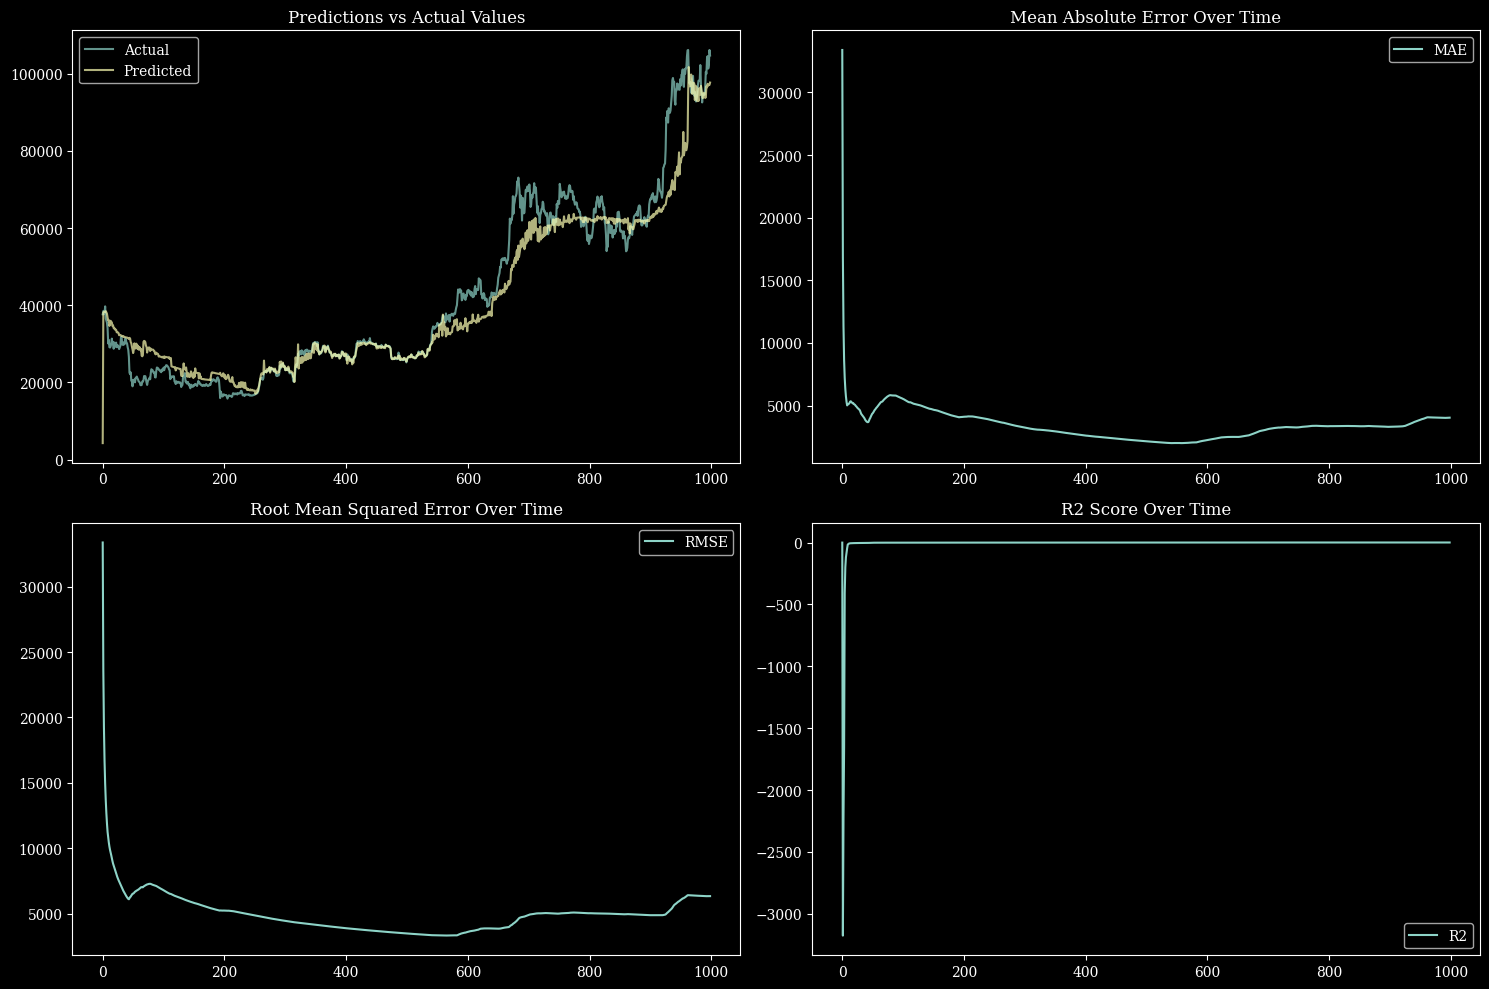


Final Metrics:
MAE: 4031.6303
RMSE: 6338.3322
R2: 0.9260

Prediction Statistics:
              Actual      Predicted
count     999.000000     999.000000
mean    42255.256196   40625.880203
std     23305.487040   19881.806639
min     15781.290000    4245.572100
25%     23536.285000   26283.070562
50%     30289.520000   31222.714017
75%     62072.000000   60903.792827
max    106143.820000  101716.529742

Directional Accuracy: 61.02%


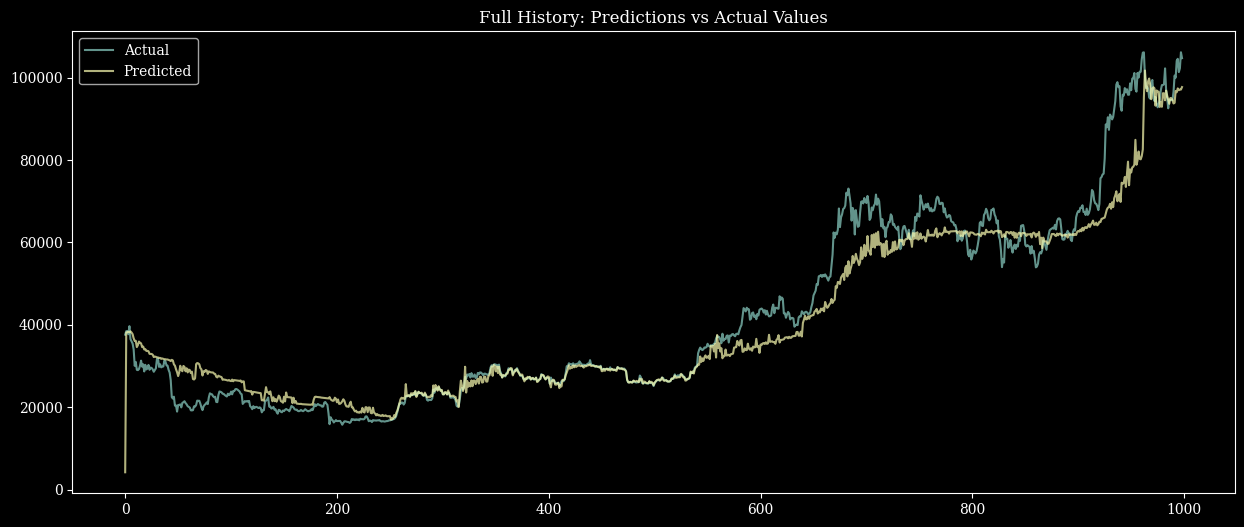

In [26]:
predict_and_plot_performance(model2, df_btc)

Processed 0 instances...
Processed 100 instances...
Processed 200 instances...
Processed 300 instances...
Processed 400 instances...
Processed 500 instances...
Processed 600 instances...
Processed 700 instances...
Processed 800 instances...
Processed 900 instances...


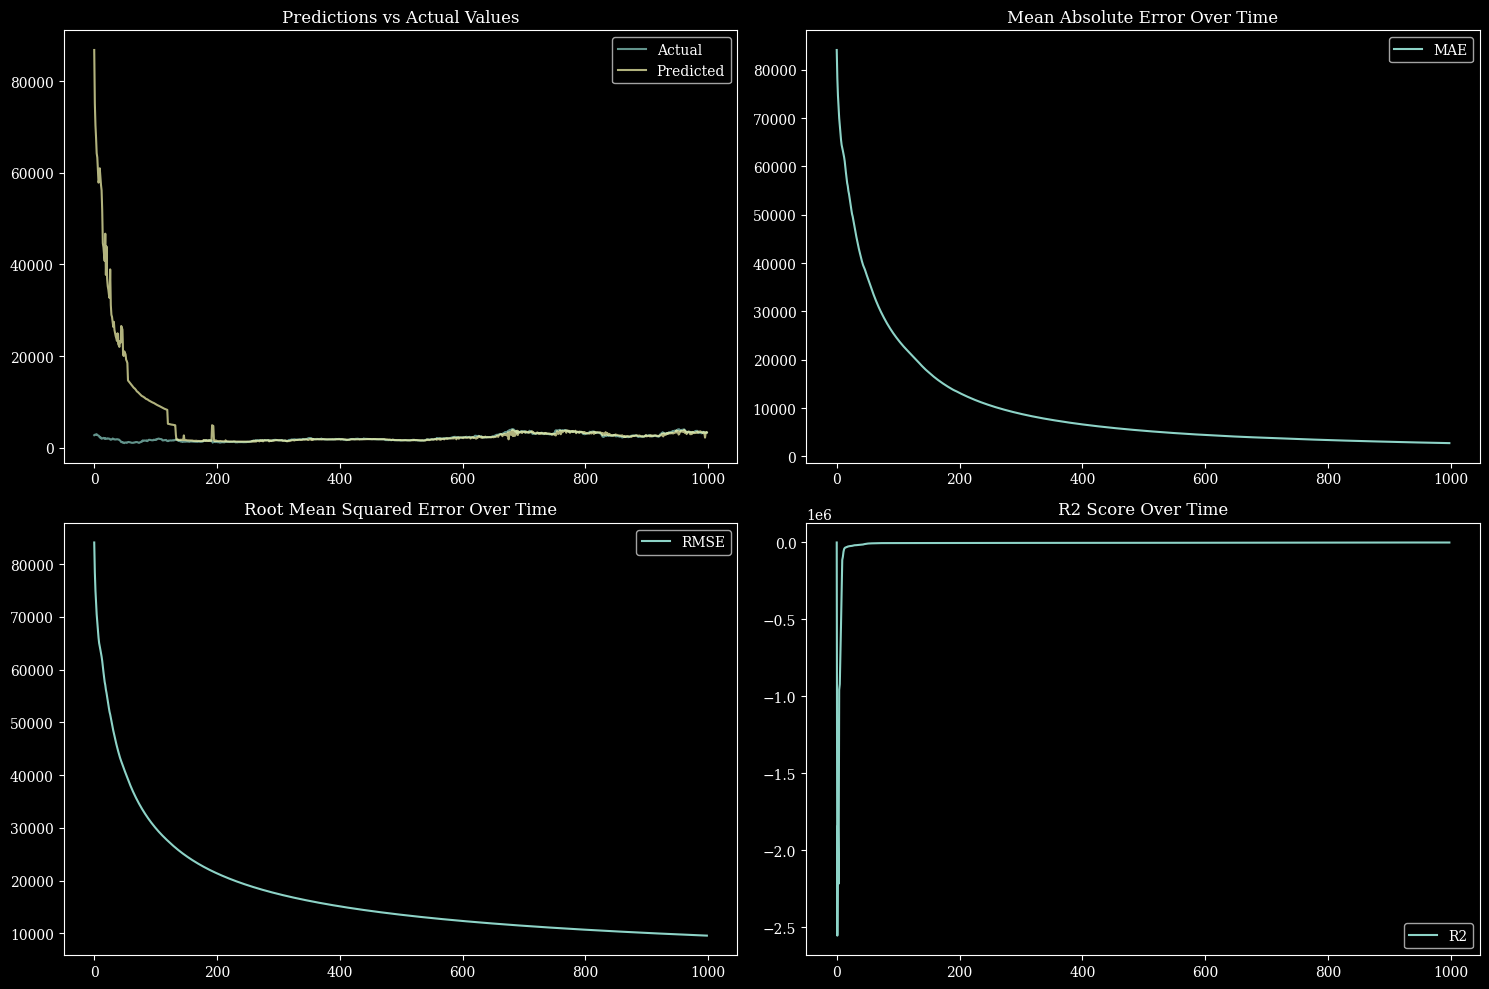


Final Metrics:
MAE: 2760.9867
RMSE: 9595.9575
R2: -148.5506

Prediction Statistics:
            Actual     Predicted
count   999.000000    999.000000
mean   2216.845435   4813.648640
std     785.075941   9186.561744
min     995.130000   1303.788424
25%    1629.070000   1698.998652
50%    1905.120000   2280.257310
75%    2793.865000   3292.387848
max    4064.800000  86815.529231

Directional Accuracy: 50.80%


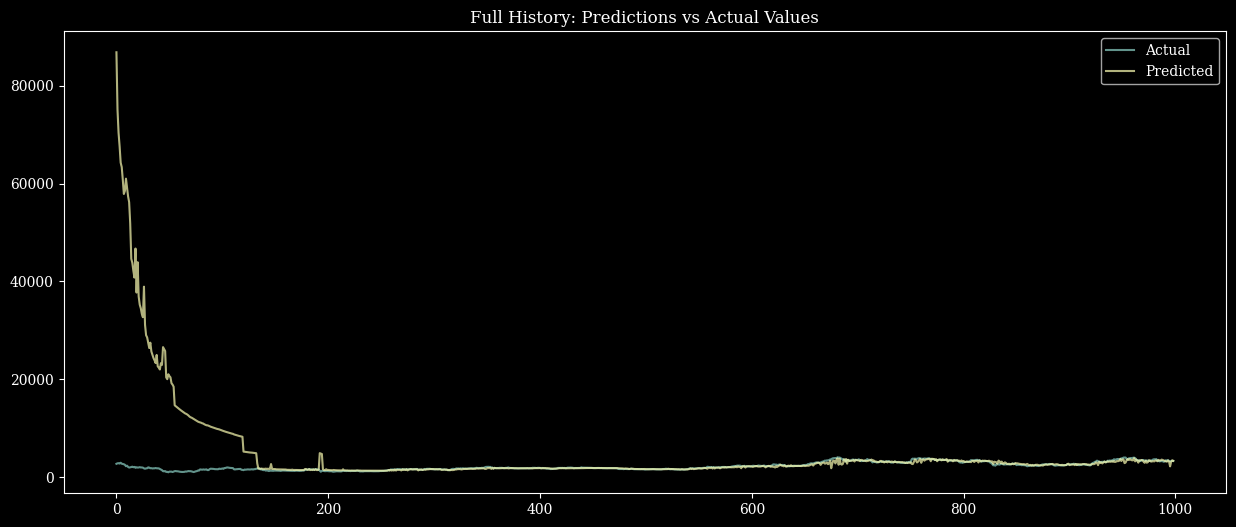

In [27]:
predict_and_plot_performance(model2, df_eth)

Processed 0 instances...
Processed 100 instances...
Processed 200 instances...
Processed 300 instances...
Processed 400 instances...
Processed 500 instances...
Processed 600 instances...
Processed 700 instances...
Processed 800 instances...
Processed 900 instances...


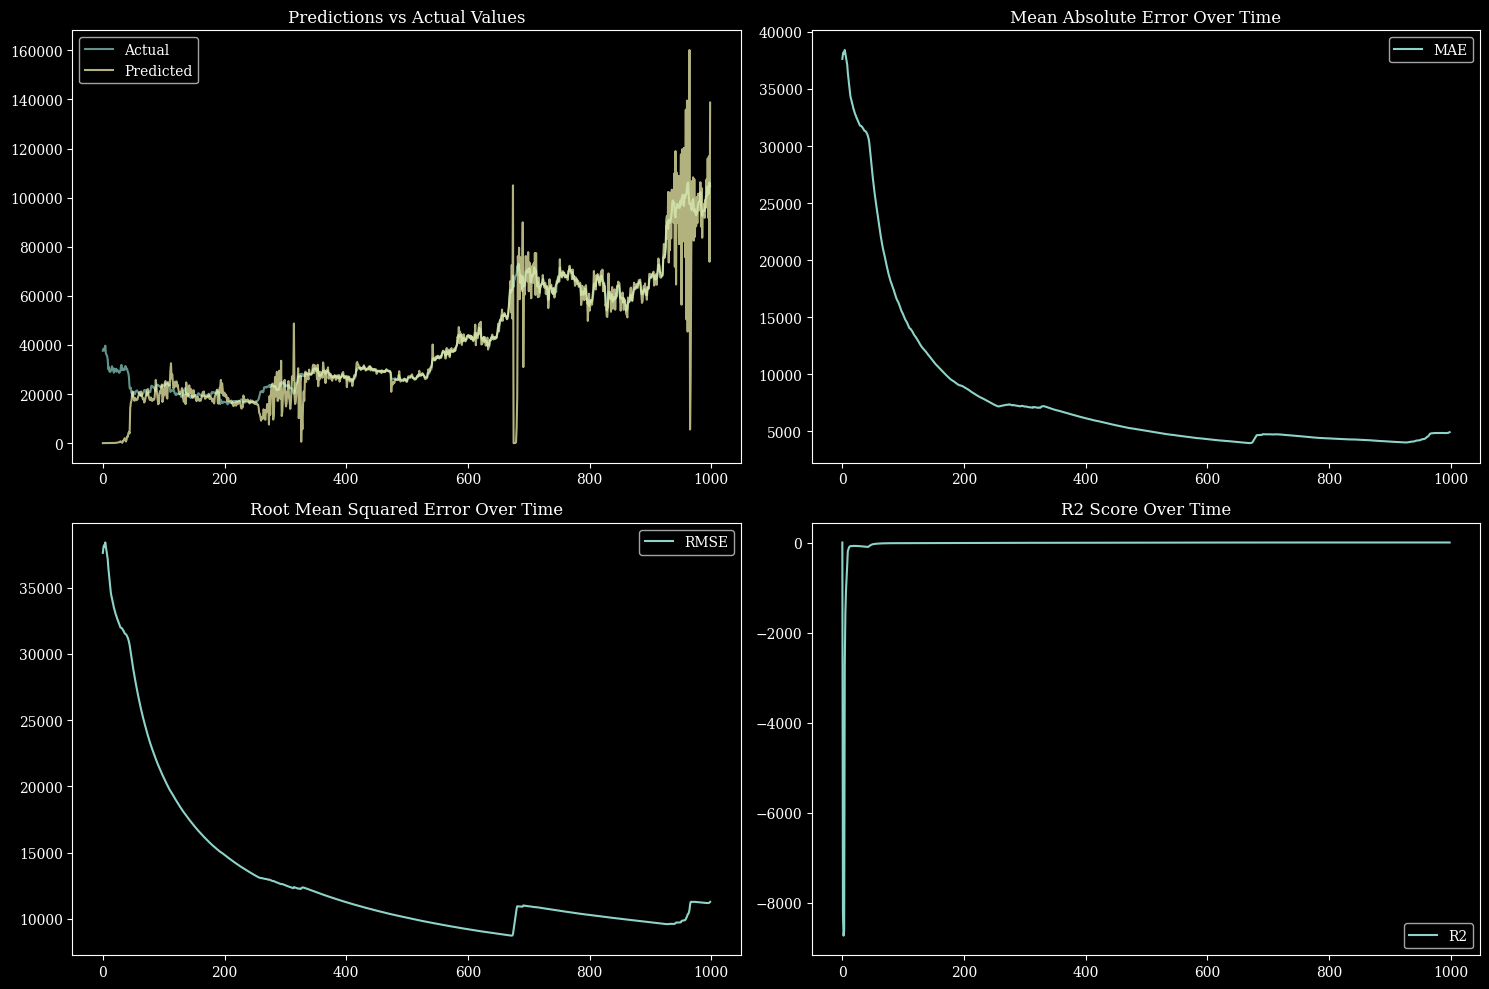


Final Metrics:
MAE: 4941.3404
RMSE: 11281.3203
R2: 0.7654

Prediction Statistics:
              Actual      Predicted
count     999.000000     999.000000
mean    42255.256196   39773.737951
std     23305.487040   25813.883576
min     15781.290000       0.000000
25%     23536.285000   20297.189027
50%     30289.520000   29578.102091
75%     62072.000000   60743.579023
max    106143.820000  160159.916650

Directional Accuracy: 58.82%


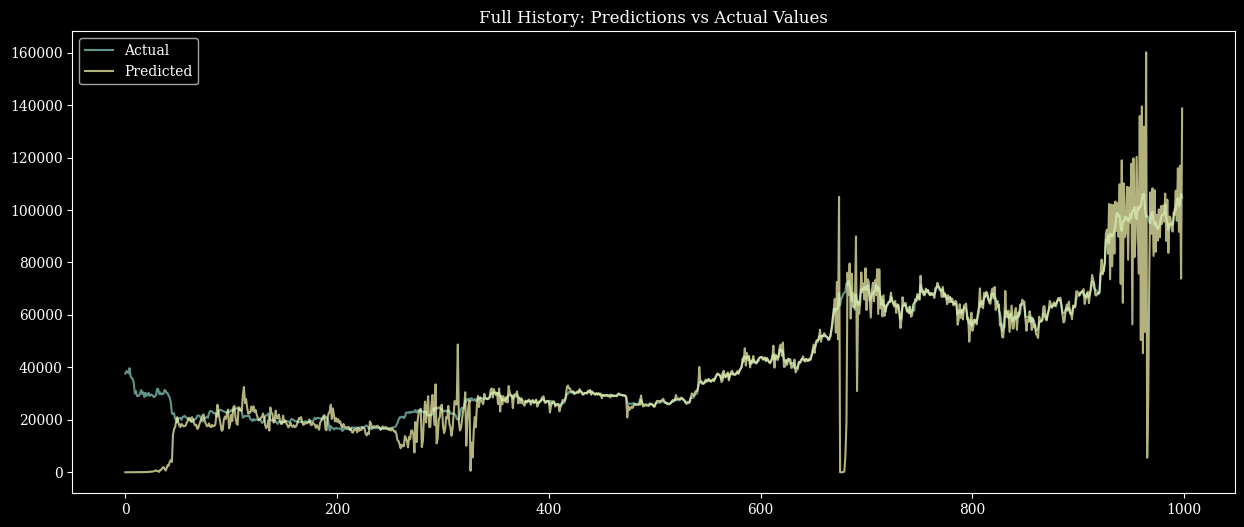

In [43]:
# reset weights of the model
model3 = (
    preprocessing.StandardScaler() |
    nn.MLPRegressor(
        hidden_dims=(5,),
        activations=(
            nn.activations.ReLU,
            nn.activations.ReLU,
            nn.activations.Identity
        ),
        optimizer=optim.SGD(1e-6),
        seed=666
    )
)

predict_and_plot_performance(model3, df_btc)

---